In [1]:
from pathlib import Path
import random
import os
from importlib import reload

import warnings
# Ignore pandas deprecation warning
warnings.filterwarnings("ignore", "\nPyarrow", DeprecationWarning)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
from tqdm.auto import tqdm


In [2]:
# BASE_PATH = Path("/kaggle/input/hms-harmful-brain-activity-classification")
BASE_PATH = Path("data/")
# SPEC_DIR = Path("/tmp/dataset/hms-hbac") # where to save the spectrograms after converting to numpy
SPEC_DIR = Path("data/spectrograms_npy")

class_names = ['Seizure', 'LPD', 'GPD', 'LRDA','GRDA', 'Other']
label2name = dict(enumerate(class_names))
name2label = {v:k for k, v in label2name.items()}

## Get data

In [3]:
import utils.data_handling
utils.data_handling.BASE_PATH = BASE_PATH
utils.data_handling.SPEC_DIR = SPEC_DIR

from utils.data_handling import metadata_df, process_all_specs, create_spec_npy_dirs
# Run this to convert the spectrograms to .npy
if False:
    create_spec_npy_dirs()
    process_all_specs()
    
metadata = metadata_df("train")
metadata_test = metadata_df("test")
display(metadata.head(2))


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec_npy_path,class_label
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0,data/train_eegs/1628180742.parquet,data/train_spectrograms/353733.parquet,data/spectrograms_npy/train_spectrograms/35373...,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0,data/train_eegs/1628180742.parquet,data/train_spectrograms/353733.parquet,data/spectrograms_npy/train_spectrograms/35373...,0


In [17]:
metadata_test

,spectrogram_id,eeg_id,patient_id,eeg_path,spec_path,spec_npy_path
0,853520,3911565283,6885,data/test_eegs/3911565283.parquet,data/test_spectrograms/853520.parquet,data/spectrograms_npy/test_spectrograms/853520...


## Visualize data

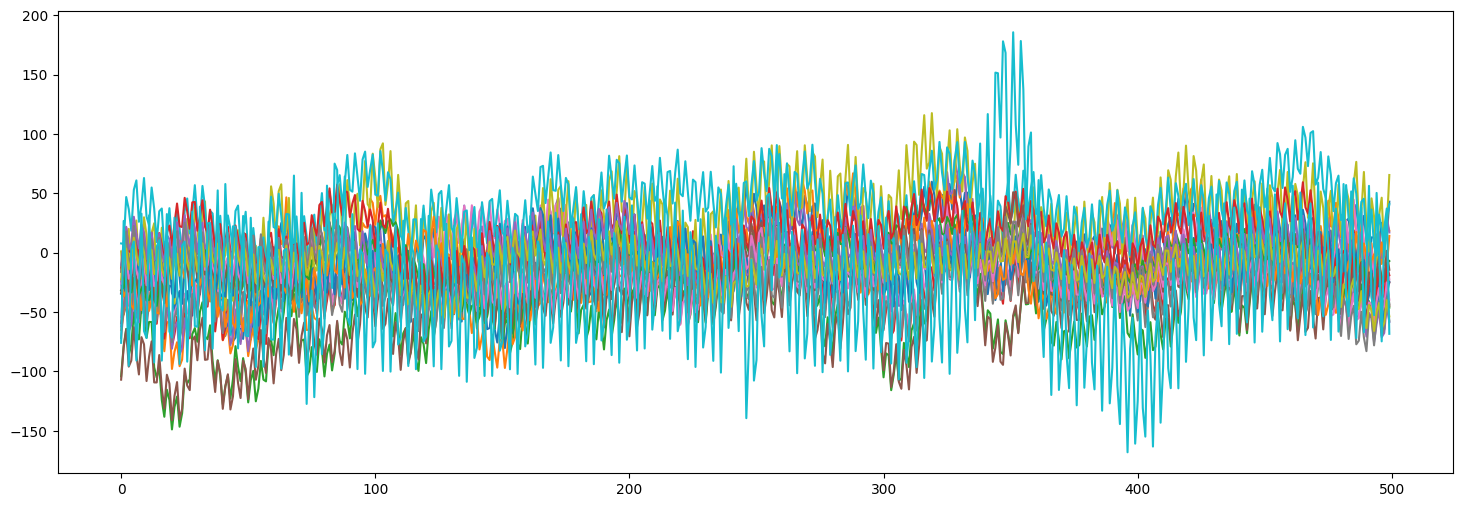

In [4]:
an_eeg = pd.read_parquet(metadata[metadata.expert_consensus == 'LPD'].iloc[0].eeg_path)
plt.figure(figsize=(18, 6))
plt.plot(an_eeg.iloc[:500]);

In [5]:
metadata.groupby("eeg_id").count()["eeg_sub_id"].value_counts()

eeg_sub_id
1      6324
2      1973
3      1430
4      1318
5       942
       ... 
101       1
85        1
236       1
210       1
226       1
Name: count, Length: 147, dtype: int64

In [90]:
idx = random.randint(0, len(metadata))
metadata.iloc[idx]

eeg_id                                                                     3129576740
eeg_sub_id                                                                         28
eeg_label_offset_seconds                                                        142.0
spectrogram_id                                                              764146759
spectrogram_sub_id                                                                735
spectrogram_label_offset_seconds                                              12830.0
label_id                                                                   3658101623
patient_id                                                                      30631
expert_consensus                                                                  LPD
seizure_vote                                                                        0
lpd_vote                                                                            7
gpd_vote                                              

In [91]:
spec_parquet = pd.read_parquet(metadata.iloc[idx].spec_path)
spec_parquet.shape

(9116, 401)

In [92]:
spec_parquet.columns[101:201]

Index(['RL_0.59', 'RL_0.78', 'RL_0.98', 'RL_1.17', 'RL_1.37', 'RL_1.56',
       'RL_1.76', 'RL_1.95', 'RL_2.15', 'RL_2.34', 'RL_2.54', 'RL_2.73',
       'RL_2.93', 'RL_3.13', 'RL_3.32', 'RL_3.52', 'RL_3.71', 'RL_3.91',
       'RL_4.1', 'RL_4.3', 'RL_4.49', 'RL_4.69', 'RL_4.88', 'RL_5.08',
       'RL_5.27', 'RL_5.47', 'RL_5.66', 'RL_5.86', 'RL_6.05', 'RL_6.25',
       'RL_6.45', 'RL_6.64', 'RL_6.84', 'RL_7.03', 'RL_7.23', 'RL_7.42',
       'RL_7.62', 'RL_7.81', 'RL_8.01', 'RL_8.2', 'RL_8.4', 'RL_8.59',
       'RL_8.79', 'RL_8.98', 'RL_9.18', 'RL_9.38', 'RL_9.57', 'RL_9.77',
       'RL_9.96', 'RL_10.16', 'RL_10.35', 'RL_10.55', 'RL_10.74', 'RL_10.94',
       'RL_11.13', 'RL_11.33', 'RL_11.52', 'RL_11.72', 'RL_11.91', 'RL_12.11',
       'RL_12.3', 'RL_12.5', 'RL_12.7', 'RL_12.89', 'RL_13.09', 'RL_13.28',
       'RL_13.48', 'RL_13.67', 'RL_13.87', 'RL_14.06', 'RL_14.26', 'RL_14.45',
       'RL_14.65', 'RL_14.84', 'RL_15.04', 'RL_15.23', 'RL_15.43', 'RL_15.63',
       'RL_15.82', 'RL_16.02'

In [93]:
spec_parquet.tail()

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,RP_18.16,RP_18.36,RP_18.55,RP_18.75,RP_18.95,RP_19.14,RP_19.34,RP_19.53,RP_19.73,RP_19.92
9111,18223,16.100000,23.610001,31.080000,34.439999,25.700001,14.590000,13.61,10.510000,9.67,...,0.07,0.08,0.07,0.04,0.03,0.02,0.02,0.02,0.02,0.03
9112,18225,5.030000,12.730000,13.000000,11.530000,12.430000,14.100000,12.00,8.560000,10.12,...,0.06,0.08,0.04,0.04,0.03,0.03,0.03,0.02,0.03,0.02
9113,18227,24.719999,22.629999,23.360001,26.160000,9.000000,14.380000,12.51,6.960000,7.32,...,0.10,0.08,0.06,0.04,0.02,0.03,0.03,0.04,0.04,0.03
9114,18229,26.990000,31.400000,34.669998,28.889999,29.500000,13.650000,13.35,18.469999,4.73,...,0.06,0.06,0.04,0.04,0.02,0.03,0.04,0.03,0.03,0.03
9115,18231,14.030000,17.650000,23.170000,25.590000,18.240000,18.799999,13.33,8.560000,7.36,...,0.03,0.04,0.05,0.05,0.06,0.06,0.05,0.04,0.03,0.04


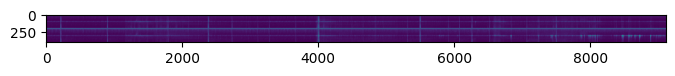

In [94]:
img = spec_parquet.iloc[:, 1:].values
img = np.log1p(img)
img = img.transpose()
img -= img.min()
img /= img.max() + 1e-4
plt.figure(figsize=(8,8))
plt.imshow(img)

In [95]:
metadata[metadata.eeg_id == metadata.iloc[idx].eeg_id]

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote,eeg_path,spec_path,spec_npy_path,class_label
39611,3129576740,0,0.0,764146759,707,12688.0,401140105,30631,LPD,0,4,0,0,0,0,data/train_eegs/3129576740.parquet,data/train_spectrograms/764146759.parquet,data/spectrograms_npy/train_spectrograms/76414...,1
39612,3129576740,1,12.0,764146759,708,12700.0,1616027706,30631,LPD,0,4,0,0,0,0,data/train_eegs/3129576740.parquet,data/train_spectrograms/764146759.parquet,data/spectrograms_npy/train_spectrograms/76414...,1
39613,3129576740,2,14.0,764146759,709,12702.0,1279201432,30631,LPD,0,4,0,0,0,0,data/train_eegs/3129576740.parquet,data/train_spectrograms/764146759.parquet,data/spectrograms_npy/train_spectrograms/76414...,1
39614,3129576740,3,16.0,764146759,710,12704.0,2037800206,30631,LPD,0,4,0,0,0,0,data/train_eegs/3129576740.parquet,data/train_spectrograms/764146759.parquet,data/spectrograms_npy/train_spectrograms/76414...,1
39615,3129576740,4,18.0,764146759,711,12706.0,1149841318,30631,LPD,0,4,0,0,0,0,data/train_eegs/3129576740.parquet,data/train_spectrograms/764146759.parquet,data/spectrograms_npy/train_spectrograms/76414...,1
39616,3129576740,5,24.0,764146759,712,12712.0,2947535654,30631,LPD,0,4,0,0,0,0,data/train_eegs/3129576740.parquet,data/train_spectrograms/764146759.parquet,data/spectrograms_npy/train_spectrograms/76414...,1
39617,3129576740,6,34.0,764146759,713,12722.0,4166115418,30631,LPD,2,5,0,4,0,2,data/train_eegs/3129576740.parquet,data/train_spectrograms/764146759.parquet,data/spectrograms_npy/train_spectrograms/76414...,1
39618,3129576740,7,36.0,764146759,714,12724.0,3730731209,30631,LPD,2,5,0,4,0,2,data/train_eegs/3129576740.parquet,data/train_spectrograms/764146759.parquet,data/spectrograms_npy/train_spectrograms/76414...,1
39619,3129576740,8,38.0,764146759,715,12726.0,3661504602,30631,LPD,2,5,0,4,0,2,data/train_eegs/3129576740.parquet,data/train_spectrograms/764146759.parquet,data/spectrograms_npy/train_spectrograms/76414...,1
39620,3129576740,9,46.0,764146759,716,12734.0,410352554,30631,LPD,2,5,0,4,0,2,data/train_eegs/3129576740.parquet,data/train_spectrograms/764146759.parquet,data/spectrograms_npy/train_spectrograms/76414...,1


Note from the "time" column that the spectrogram data samples are spaced 2 seconds apart, starting at t=1. In other words, the parquet row is related to `time` by `time == 2*row + 1`. (I haven't checked this for every spectrogram!)

Each spectrogram item in the dataset is a 600-second window from the given file, starting at the even integer `spectrogram_label_offset_seconds`. In other words, the item consists of rows `[x/2:x/2+300]`, where `x=spectrogram_label_offset_seconds`.

For a better explanation that also includes the EEGs, see [this Kaggle post](https://www.kaggle.com/competitions/hms-harmful-brain-activity-classification/discussion/468010).

Time offset: 142.0 s


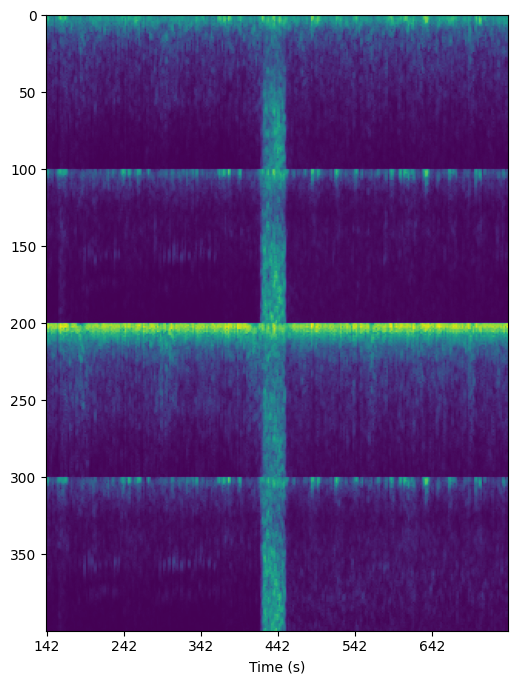

In [97]:
# Image of a single data item
x = metadata.iloc[idx].eeg_label_offset_seconds
print(f"Time offset: {x} s")
x = int(x)
img = spec_parquet.iloc[x//2:x//2+300, 1:].values
img = np.log1p(img)
img = img.transpose()
img -= img.min()
img /= img.max() + 1e-4
plt.figure(figsize=(8,8))
plt.imshow(img)
plt.xticks(np.arange(0, 300, 50), np.arange(x, x+600, 100));
plt.xlabel("Time (s)");

## Define dataset and dataloader

In [116]:
reload(utils.data_handling)

<module 'utils.data_handling' from '/home/pvk/Documents/python/ML/brains/utils/data_handling.py'>

In [117]:
from utils.data_handling import SpectrogramDataset, SpectrogramTestDataset
train = SpectrogramDataset(metadata)
test = SpectrogramTestDataset(metadata_test)
print(f"{len(train)} training items, {len(test)} testing item.")

106800 training items, 1 testing item.


In [118]:
train[0]

(tensor([[ 4.2600,  2.6500,  4.1800,  ...,  1.8700,  3.2700,  4.1800],
         [10.9800,  3.9700,  4.5300,  ...,  3.5900,  5.6300,  5.8500],
         [ 9.0500, 12.1800,  8.7700,  ...,  8.6900,  9.4600,  7.2200],
         ...,
         [ 0.1600,  0.3100,  0.4800,  ...,  0.1000,  0.0800,  0.2500],
         [ 0.2200,  0.3600,  0.4400,  ...,  0.1000,  0.1300,  0.1700],
         [ 0.1900,  0.4000,  0.4800,  ...,  0.1000,  0.1400,  0.1500]]),
 tensor([3, 0, 0, 0, 0, 0]))

In [120]:
test[0]

(tensor([[14.9100, 11.1300, 10.8800,  ...,  9.6100,  8.4300, 12.3300],
         [17.1100, 10.9500, 10.5700,  ..., 13.3200, 11.8400, 11.8400],
         [11.6600, 10.7700,  8.7900,  ...,  9.1900, 13.6400,  9.4200],
         ...,
         [ 0.0500,  0.0300,  0.0500,  ...,  0.3900,  0.4500,  0.4600],
         [ 0.0400,  0.0300,  0.0600,  ...,  0.5600,  0.4500,  0.5400],
         [ 0.0500,  0.0200,  0.0600,  ...,  0.2900,  0.3400,  0.2900]]),
 None)

In [121]:
train[0][0].shape

torch.Size([400, 300])

In [126]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train, 32)
train_batch = next(iter(train_loader))
print(train_batch[0].shape, train_batch[1].shape)

torch.Size([32, 400, 300]) torch.Size([32, 6])
